In [ ]:
!pip install neuralforecast

In [2]:
import pandas as pd
import numpy as np
from time import time
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
ROOT = "/content/drive/MyDrive/dl-project"

FEATURES = [
    'pressure_1',
    'pressure_2',
    'pressure_3',
    'pressure_4',
    'pressure_5',
    'pressure_6',
    'pressure_7'
]
SEED = 78

time_spent = {}
horizon = 187
input_size = 187

In [4]:
train = pd.read_csv(f"{ROOT}/data/train_data_scaled.csv")
test = pd.read_csv(f"{ROOT}/data/test_data_scaled.csv")

In [5]:
# Exigência do nixtla
train['unique_id'] = 'slug_flow'
train['ds'] = train['time']
train['y'] = train['liquid_flow_rate']


test['unique_id'] = 'slug_flow'
test['ds'] = test['time']
test['y'] = test['liquid_flow_rate']

### Training

In [6]:
# NHITS: https://nixtlaverse.nixtla.io/neuralforecast/models.nhits.html#nhits

models = [
    NHITS(
        h=horizon,
        input_size=input_size,
        hist_exog_list=FEATURES,
        exclude_insample_y=True,
        n_blocks=[1, 1, 1],
        mlp_units=[[512, 512], [512, 512], [512, 512]],
        n_pool_kernel_size=[2, 2, 1],
        n_freq_downsample=[4, 2, 1],
        max_steps=500,
        val_check_steps=50,
        early_stop_patience_steps=5,
        random_seed=SEED
    )
]

INFO:lightning_fabric.utilities.seed:Seed set to 78


In [7]:
start_time = time()
nf = NeuralForecast(
    models=models,
    freq=1
)

nf.fit(df=train, val_size=horizon)
time_spent['training_time'] = time() - start_time

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 4.4 M  | train
-------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.426    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


In [ ]:
print("Tempo de treinemento:", time_spent["training_time"], "seconds")

### Predictions

In [ ]:
# Junta os últimos 'input_size' pontos do treino com os dados de teste
predictions_input_df = pd.concat([train.tail(input_size), test])

In [34]:
# Cria janelas deslizantes do DataFrame para fazer predições
inputs_for_predicions_list = [
    predictions_input_df.iloc[i:i + input_size]
    for i in range(0, len(predictions_input_df) - input_size + 1, horizon)
]

In [ ]:
forecasts_list = []
for input_df in inputs_for_predicions_list:
    forecast = nf.predict(df=input_df)
    forecasts_list.append(forecast)

In [36]:
forecasts_output = pd.concat(forecasts_list)

In [37]:
forecasts_output

,unique_id,ds,NHITS
0,slug_flow,1501,0.451240
1,slug_flow,1502,0.468374
2,slug_flow,1503,0.480722
3,slug_flow,1504,0.501025
4,slug_flow,1505,0.533558
...,...,...,...
182,slug_flow,3179,0.276035
183,slug_flow,3180,0.278539
184,slug_flow,3181,0.279500
185,slug_flow,3182,0.278816


In [39]:
ground_truth = test[['unique_id', 'ds', 'y']]
ground_truth

,unique_id,ds,y
0,slug_flow,1501,0.459397
1,slug_flow,1502,0.471283
2,slug_flow,1503,0.484231
3,slug_flow,1504,0.496564
4,slug_flow,1505,0.510421
...,...,...,...
1495,slug_flow,2996,0.279759
1496,slug_flow,2997,0.279714
1497,slug_flow,2998,0.279125
1498,slug_flow,2999,0.278436


In [40]:
nhits_results = pd.merge(
    ground_truth,
    forecasts_output,
    on=['unique_id', 'ds'],
    how='left'
)
nhits_results

,unique_id,ds,y,NHITS
0,slug_flow,1501,0.459397,0.451240
1,slug_flow,1502,0.471283,0.468374
2,slug_flow,1503,0.484231,0.480722
3,slug_flow,1504,0.496564,0.501025
4,slug_flow,1505,0.510421,0.533558
...,...,...,...,...
1495,slug_flow,2996,0.279759,0.285010
1496,slug_flow,2997,0.279714,0.282774
1497,slug_flow,2998,0.279125,0.282989
1498,slug_flow,2999,0.278436,0.281811


In [42]:
nhits_results.to_csv(f"{ROOT}/results/nhists_results.csv", index=False)

### Performance Evaluation

In [43]:
y_true = nhits_results['y']
y_pred = nhits_results['NHITS']

In [44]:
print(f"MAE: {mean_absolute_error(y_true, y_pred)}")

MAE: 0.012856744433149913


In [45]:
print(f"MSE: {mean_squared_error(y_true, y_pred)}")

MSE: 0.0013723269224300075


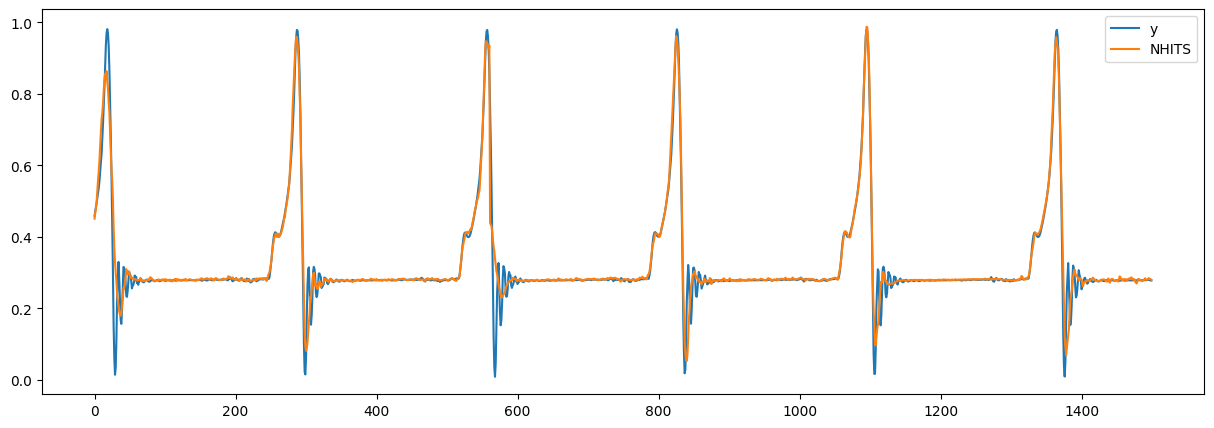

In [46]:
nhits_results[['y', 'NHITS']].plot(figsize=(15, 5));

In [47]:
# Salvar modelo
nf.save(path=f"{ROOT}/models/nhits/")